### Tweeter Sentiment Prediction Modelling

In [1]:
#! pip install spacy==2.2

In [2]:
#pip list

In [3]:
# Load dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import spacy
import en_core_web_sm
import sys
import unicodedata
import os

import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
np.random.seed(7) # seeding random number generator

In [45]:
# File paths
pred_data_file = os.path.join("..","Resources","data","tweetPredData.csv")

In [46]:
# Load Tweeter data file
df = pd.read_csv(pred_data_file)

In [47]:
# Display sample results
df.head()

,Date,Matched Keywords,User,Source,Followers,Friends,Favorite,Tweet,predTweet,CleanedTweet,Prediction
0,08/05/2020,Biden,YourSiteingGoog,IFTTT,84,198,0,Breaking #FoxNews Alert : Bien scraps plans to...,breaking foxnews alert biden scraps plans trav...,"['break', 'foxnew', 'alert', 'bien', 'scrap', ...",Positive
1,08/05/2020,Trump,rbenton75nc,Twitter for Android,15,87,0,@JRubinBlogger Isn't the doctor who gave Trump...,not the doctor who gave trump the test the sam...,"['doctor', 'trump', 'test', 'doctor', 'tri', '...",Neutral
2,08/05/2020,Trump,Mrb18101,Twitter for iPhone,72,134,0,@WindsorMann The only friends Trump has had hi...,the only friends trump has had his entire life...,"['friend', 'trump', 'entir', 'life', 'one', 'b...",Positive
3,08/05/2020,Trump,mermansteve,Twitter Web App,5232,5664,0,Trump’s pick to manage public lands has four-d...,trumps pick manage public lands has fourdecade...,"['trump', 'pick', 'manag', 'public', 'land', '...",Negative
4,08/05/2020,Trump,biospherian,Twitter Web App,26,167,0,Because Trump is an asshole: http://t.co/Is5rk...,because trump an asshole,"['trump', 'asshol']",Neutral


In [48]:
# Describe data set
df.describe()

,Followers,Friends,Favorite
count,5.959100e+04,59591.000000,59591.000000
mean,2.773664e+04,2917.913393,7.629390
std,5.234116e+05,12186.536039,239.620822
min,0.000000e+00,0.000000,0.000000
25%,7.300000e+01,180.500000,0.000000
50%,4.090000e+02,635.000000,0.000000
75%,2.190000e+03,2070.000000,1.000000
max,4.936664e+07,872101.000000,45536.000000


In [50]:
# Keep only required columns
df_pred = df[['predTweet','CleanedTweet','Prediction']]

In [51]:
# Check df stats
df_pred.describe()

,predTweet,CleanedTweet,Prediction
count,59591,59591,59591
unique,54342,53084,3
top,trump,['trump'],Negative
freq,254,484,24256


In [54]:
# Check data dimension - this step is required to make sure we have enough data points to train and test model
df_pred.shape

(59591, 3)

In [60]:
# Select meaningful reviews by filtering reviews with more than 10 words in the review comment.
df_pred = df_pred[df_pred['predTweet'].fillna("").apply(lambda x: len(x.split())>=10)] 

In [61]:
# Check the data dimension
df_pred.shape

(46878, 3)

In [62]:
# Lemmatization and Stop words
nlp = en_core_web_sm.load()

# Define default stopwords list
stoplist = spacy.lang.en.STOP_WORDS 

# Functions to remove encodes
def replace_ptbr_char_by_word(word):
    #  """ Will remove the encode token by token"""
    word = str(word)
    word = unicodedata.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def remove_pt_br_char_by_text(text):
    #  """ Will remove the encode using the entire text"""
    text = str(text)
    text = " ".join(replace_ptbr_char_by_word(word) for word in text.split() if word not in stoplist)
    return text

In [63]:
# Lemmatization and Stop words
df_pred['predTweet'] = df_pred['predTweet'].apply(remove_pt_br_char_by_text)

In [64]:
# Keep only required columns
df_pred=df_pred[['predTweet','Prediction']]

In [65]:
# Check data types
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46878 entries, 0 to 59590
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   predTweet   46878 non-null  object
 1   Prediction  46878 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [66]:
# Convert review_body to text
df_pred['predTweet'] = df_pred['predTweet'].astype(str)

In [67]:
# Display df sample
df_pred.head()

,predTweet,Prediction
0,breaking foxnews alert biden scraps plans trav...,Positive
1,doctor gave trump test doctor tried head va qu...,Neutral
2,friends trump entire life ones bought money tr...,Positive
3,trumps pick manage public lands fourdecade his...,Negative
6,trump sort president failed oh hard cognitive ...,Negative


### Calculate Term Frequencies
- Calculate both the actual term frequency as well as the tfidf weighted term frequency. Let's limit words occuring in at most 90% of documents and in at least 10 documents. 
- The term-frequency matrix is just a word count, the IDF calculation adjusts for "boring" or "irrelvant" words that occur in many reviews.

- Perform two tokenizing operations. First, tokenize only letters, ignoring special symbols & numbers. 
- Use the NLTK Snowball stemmer to try and get the root of a word as best as possible. Stop words are removed in the vectorization step.

In [68]:
# Calculate TD and IDF
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

tf_m, tf_d = get_tf(df_pred['predTweet'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(df_pred['predTweet'], use_idf=True, max_df=0.90, min_df=10)

### Compute topics using Kmeans and LDA

- Kmeans approach: Using our TFIDF matrix, cluster documents into N clusters based on their TFIDF similarity. Within each cluster, count the top occuring terms.

- LDA approach: Using TF matrix, attempt to extact N topics from the collection of documents.

##### Note: Kmeans forces each review to belong to only one cluster while LDA allows a review to have many topics associated with it. 

In [69]:
# Let's choose 15 topics
n_topics = 10

# LDA Approach
def get_lda(data, topics):
    m = LatentDirichletAllocation(n_components=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

# Kmeans Approach
def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

### Show cluster top 10 words per topic
- First extract the top 10 stemmed words per topic in our LDA model. 
- Repeate process for kmeans clustered documents. 

##### Note: Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [70]:
# Show topics
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
# Show Clusters    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()

In [71]:
# LDA topic 
print("Top 10 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 10)

Top 10 stemmed words per topic in LDA model

Topic #0:
trump, death, debat, like, ask, look, hes, tiktok, media, deal
Topic #1:
trump, vote, elect, covid, presid, republican, america, peopl, want, state
Topic #2:
trump, right, said, lewi, john, come, start, rememb, know, didnt
Topic #3:
biden, joe, democrat, news, plan, accept, swan, presid, coronavirus, china
Topic #4:
trump, biden, peopl, need, test, black, think, american, year, like
Topic #5:
trump, white, hous, follow, new, million, speech, law, leader, usa
Topic #6:
trump, talk, like, obama, bad, lose, love, peopl, care, tell
Topic #7:
trump, say, support, fuck, actual, thing, biden, fake, laugh, know
Topic #8:
trump, campaign, school, money, say, open, make, fraud, corrupt, kid
Topic #9:
trump, interview, presid, like, world, watch, offic, donald, time, want



In [72]:
# Kmean cluster of words
print("Top 10 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(),20)

Top 10 stemmed words per cluster in Kmeans model

Cluster #0:
school, open, kid, trump, reopen, children, barron, send, close, want, teacher, virus, covid, presid, say, son, parent, like, safe, push
Cluster #1:
want, trump, peopl, biden, know, like, vote, presid, debat, think, support, elect, american, doesnt, democrat, america, say, need, tiktok, joe
Cluster #2:
lie, trump, say, time, know, biden, claim, fals, peopl, truth, hemingway, trackrecord, molli, examin, like, arrest, bizarr, american, virus, fact
Cluster #3:
vote, mail, trump, mailin, ballot, biden, state, peopl, elect, florida, nevada, republican, voter, democrat, win, right, im, need, think, tri
Cluster #4:
presid, trump, donald, like, obama, american, peopl, elect, biden, america, state, know, say, year, said, countri, unit, think, need, republican
Cluster #5:
biden, joe, vp, debat, pick, democrat, run, think, like, elect, win, know, campaign, peopl, obama, time, need, candid, basement, parti
Cluster #6:
trump, like, donal

## Prepare data for plotting
- TF/TFIDF matricies is a challenge to graphically represent documents as charts are limited to 3 dimensions. 
- Perform a heirarchical clustering, but the number of documents makes this approach very slow. 
- Let's perform a SVD/LSA to reduce the dimensionality of the matrix to something more manageable (eg. 30 dimensions).

In [73]:

def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 30)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

### Plot Data
- Use LDA and Kmeans labels with reduced dimensions to plot our documents. 
- Create a rainbow color scheme which allows for a variable number of topics/clusters. 
- The plot tends to overlap quite a bit.  

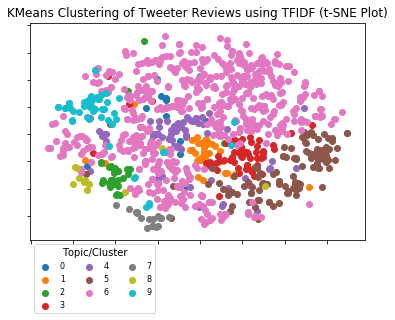

In [75]:
# Cluster topc plot
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

# Plot
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Tweeter Sentiment using TFIDF (t-SNE Plot)')

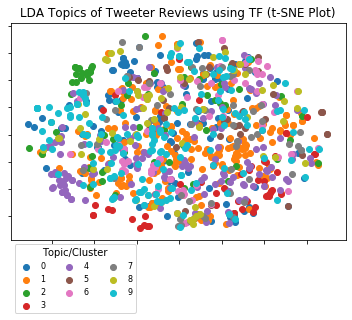

In [76]:
# LDA topics plot
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Tweeter Sentiment using TF (t-SNE Plot)')

### Prepare data for prediction
- Scatter plots helps to understand how the data is structured, but it doesn't tell what drives positive or negative reviews. - - Lets use words within reviews to build a predictive scoring model.
- When training models, split the data 70%/30% where 30% will be used for prediction to gauge final accuracy of the model.
- For each review, the model that scores the highest will tell us which kind of review it likely is.

In [77]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, df_pred['Prediction'], test_size=0.3)

### Calculate model accuracies
- Three different approaches to build the review predictions: Logistic Regression, Naive Bayes, and Support Vector Machines. 
- Final approach that does a combined "vote" of all three models. 
- Since we have limited data, lets use cross-validation to split the data 10 ways and measure accuracy in an unbiased way.

In [80]:
# Calculate cross validation score
cat = ["Positive","Negative","Neutral"]
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

# Call function
cv_scores = calculate_cv(X_test, y_test)

# print model accuracy predictions

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

Model accuracy predictions

LR model (Positive rating): 77.3%
LR model (Negative rating): 75.6%
LR model (Neutral rating): 82.7%

SVM model (Positive rating): 77.9%
SVM model (Negative rating): 75.0%
SVM model (Neutral rating): 83.3%

NB model (Positive rating): 72.3%
NB model (Negative rating): 72.3%
NB model (Neutral rating): 81.0%

COMBINED model (Positive rating): 77.3%
COMBINED model (Negative rating): 75.2%
COMBINED model (Neutral rating): 82.9%



### Training the model of choice
- SVM have given better performance for. There is definitely room for improvement.  

- There are lots of ways to tweak the prior steps to get a better result.

    - Tweak any parameters in either the TF step or the modeling step
    - Neg/Pos keywords might vary by topic so we might do this for one cluster at a time
    - Nouns don't provide much insight and we are better off removing them
    - "good" and "not good" have opposite meanings so maybe we should have included 2-grams

In [81]:
# Build linear regression model and fit 
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

### Plot the results
- Charts show the result of Logistic Regression model. 
- Top 10 words negatively associated (red) with that review model, and the top 10 words positively associated (green) with that review model. 
- The values indiciate how much more likely or unlikely a review is to be low, neutral, high given the # of times that word occurs in the review.

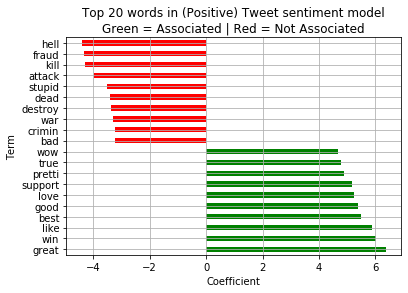

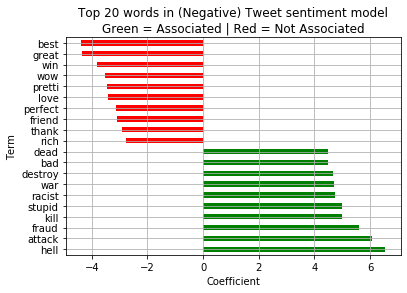

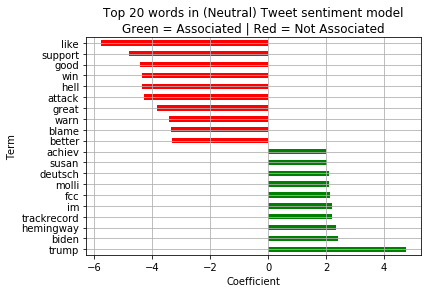

In [83]:
# Plot coefficient 

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    
    df['c'] = df['Coefficient']>0
    
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    
    ax.set_xlabel("Coefficient")

n_terms = 10
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) Tweet sentiment model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, 
               R=cat[c]), lr_m[c], tfidf_m.get_feature_names(), n_terms)

### Test output
- Below is a test function which allows to supply review to see how well the model will predict it's rating. 
- For simplicity, logistic regression model is used and only allow for one review at a time.
- The program uses the stored TFIDF matrix to tokenize and transform our new review which is then fed to all three of logistic regression models. 
- Each model has an independent assessment of how likely it is that our review is a positive hit.  

In [84]:
# Function to test sentiment
def test_sentiment(text,model):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Tweet text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=model[m].predict_proba(test_new)[0][1]))       

In [85]:
# Bad sentiment
test_sentiment('President Trump killed too many people because his COVID19 policies. He should have shut country in early stage.',lr_m)

Tweet text: "President Trump killed too many people because his COVID19 policies. He should have shut country in early stage."

Model Predction
Model (Positive): 6.0%
Model (Negative): 64.2%
Model (Neutral): 34.1%


In [86]:
# Good sentiment
test_sentiment('President Trump kept his word on trade policies. He is great for the businesses.',lr_m)

Tweet text: "President Trump kept his word on trade policies. He is great for the businesses."

Model Predction
Model (Positive): 67.5%
Model (Negative): 8.6%
Model (Neutral): 26.3%


### Save Model

In [ ]:
# Need to save 3 models